In [12]:

import importlib.metadata
__version__ = importlib.metadata.version('pyNNRW')

import numpy as np

def to_categorical(y, num_classes=None, dtype="float32"):
    """
    This function is copied from keras.

    Converts a class vector (integers) to binary class matrix.

    E.g. for use with `categorical_crossentropy`.

    Args:
        y: Array-like with class values to be converted into a matrix
            (integers from 0 to `num_classes - 1`).
        num_classes: Total number of classes. If `None`, this would be inferred
          as `max(y) + 1`.
        dtype: The data type expected by the input. Default: `'float32'`.

    Returns:
        A binary matrix representation of the input. The class axis is placed
        last.

    Example:

    >>> a = tf.keras.utils.to_categorical([0, 1, 2, 3], num_classes=4)
    >>> a = tf.constant(a, shape=[4, 4])
    >>> print(a)
    tf.Tensor(
      [[1. 0. 0. 0.]
       [0. 1. 0. 0.]
       [0. 0. 1. 0.]
       [0. 0. 0. 1.]], shape=(4, 4), dtype=float32)

    >>> b = tf.constant([.9, .04, .03, .03,
    ...                  .3, .45, .15, .13,
    ...                  .04, .01, .94, .05,
    ...                  .12, .21, .5, .17],
    ...                 shape=[4, 4])
    >>> loss = tf.keras.backend.categorical_crossentropy(a, b)
    >>> print(np.around(loss, 5))
    [0.10536 0.82807 0.1011  1.77196]

    >>> loss = tf.keras.backend.categorical_crossentropy(a, a)
    >>> print(np.around(loss, 5))
    [0. 0. 0. 0.]
    """
    y = np.array(y, dtype="int")
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

'''
This ELM implementation is based on https://github.com/otenim/Numpy-ELM: 

MIT License

Copyright (c) 2019 Otenim

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
'''

import os
import numpy as np
import h5py
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV, train_test_split
# from . import to_categorical
from sklearn.metrics import log_loss, accuracy_score, recall_score
from sklearn.preprocessing import OneHotEncoder
# from keras import losses

def _mean_squared_error(y_true, y_pred):
    return 0.5 * np.mean((y_true - y_pred)**2)

def _mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _identity(x):
    return x

def _relu(x):
    return np.maximum(0, x)

def softmax(x):
    c = np.max(x, axis=-1)
    upper = np.exp(x - c)
    lower = np.sum(upper, axis=-1)
    return upper / lower

class ELM(object):
    def __init__(
        self, n_input_nodes, n_hidden_nodes, n_output_nodes,
        activation='sigmoid', loss='mean_squared_error', name=None,
        beta_init=None, alpha_init=None, bias_init=None):

        self.name = name
        self.__n_input_nodes = n_input_nodes
        self.__n_hidden_nodes = n_hidden_nodes
        self.__n_output_nodes = n_output_nodes

        # initialize weights and a bias
        if isinstance(beta_init, np.ndarray):
            if beta_init.shape != (self.__n_hidden_nodes, self.__n_output_nodes):
                raise ValueError(
                    'the shape of beta_init is expected to be (%d,%d).' % (self.__n_hidden_nodes, self.__n_output_nodes)
                )
            self.__beta = beta_init
        else:
            self.__beta = np.random.uniform(-1.,1.,size=(self.__n_hidden_nodes, self.__n_output_nodes))
        if isinstance(alpha_init, np.ndarray):
            if alpha_init.shape != (self.__n_input_nodes, self.__n_hidden_nodes):
                raise ValueError(
                    'the shape of alpha_init is expected to be (%d,%d).' % (self.__n_hidden_nodes, self.__n_output_nodes)
                )
            self.__alpha = alpha_init
        else:
            self.__alpha = np.random.uniform(-1.,1.,size=(self.__n_input_nodes, self.__n_hidden_nodes))
        if isinstance(bias_init, np.ndarray):
            if bias_init.shape != (self.__n_hidden_nodes,):
                raise ValueError(
                    'the shape of bias_init is expected to be (%d,).' % (self.__n_hidden_nodes,)
                )
            self.__bias = bias_init
        else:
            self.__bias = np.zeros(shape=(self.__n_hidden_nodes,))

        # set an activation function
        self.__activation = self.__get_activation_function(activation)

        # set a loss function
        self.__loss = self.__get_loss_function(loss)

    # FP
    def __call__(self, x):
        print(x.shape)
        print(self.__alpha.shape)
        print(self.__bias.shape)
        h = self.__activation(x.dot(self.__alpha) + self.__bias)
        return h.dot(self.__beta)

    def predict(self, x):
        return np.array(self(x))

    def evaluate(self, x, t, metrics=['loss']):
        y_pred = self.predict(x)
        y_true = t
        y_pred_argmax = np.argmax(y_pred, axis=-1)
        y_true_argmax = np.argmax(y_true, axis=-1)
        ret = []
        for m in metrics:
            if m == 'loss':
                loss = self.__loss(y_true, y_pred)
                ret.append(loss)
            elif m == 'accuracy':
                acc = np.mean(y_pred_argmax == y_true_argmax)
                ret.append(acc)
            elif m == 'precision':
                num_classes = t.shape[1] # len(t[0])
                precision = []
                for i in range(num_classes):
                    tp = np.sum((y_pred_argmax == i) & (y_true_argmax == i))
                    tp_fp = np.sum(y_pred_argmax == i)
                    precision.append(tp / tp_fp)
                ret.append(np.mean(precision))
            elif m == 'recall':
                num_classes = t.shape[1] # len(t[0])
                recall = []
                for i in range(num_classes):
                    tp = np.sum((y_pred_argmax == i) & (y_true_argmax == i))
                    tp_fn = np.sum(y_true_argmax == i)
                    recall.append(tp / tp_fn)
                ret.append(np.mean(recall))
            else:
                raise ValueError(
                    'an unknown evaluation indicator \'%s\'.' % m
                )
        if len(ret) == 1:
            ret = ret[0]
        elif len(ret) == 0:
            ret = None
        return ret

    def _transform_label(self, y):
        enc = OneHotEncoder(handle_unknown='ignore')
        try:
            target = enc.fit_transform(y).toarray()
            # print('the label can be transformed directly using onehotencoder')
        except:
            target = enc.fit_transform(y.reshape(-1, 1)).toarray()
            # print('the label must be reshaped before being transformed')
        return target

    def fit(self, x, t):
        one_hot_target = self._transform_label(t)

        H = self.__activation(x.dot(self.__alpha) + self.__bias)

        # compute a pseudoinverse of H
        H_pinv = np.linalg.pinv(H)

        # update beta
        self.__beta = H_pinv.dot(one_hot_target)

    def save(self, filepath):
        with h5py.File(filepath, 'w') as f:
            arc = f.create_dataset('architecture', data=np.array([self.__n_input_nodes, self.__n_hidden_nodes, self.__n_output_nodes]))
            arc.attrs['activation'] = self.__get_activation_name(self.__activation).encode('utf-8')
            arc.attrs['loss'] = self.__get_loss_name(self.__loss).encode('utf-8')
            arc.attrs['name'] = self.name.encode('utf-8')
            f.create_group('weights')
            f.create_dataset('weights/alpha', data=self.__alpha)
            f.create_dataset('weights/beta', data=self.__beta)
            f.create_dataset('weights/bias', data=self.__bias)

    def __get_activation_function(self, name):
        if name == 'sigmoid':
            return _sigmoid
        elif name == 'identity':
            return _identity
        elif name == 'relu':
            return _relu
        else:
            raise ValueError(
                'an unknown activation function \'%s\'.' % name
            )

    def __get_activation_name(self, activation):
        if activation == _sigmoid:
            return 'sigmoid'
        elif activation == _identity:
            return 'identity'

    def __get_loss_function(self, name):
        if name == 'mean_squared_error':
            return _mean_squared_error
        elif name == 'mean_absolute_error':
            return _mean_absolute_error
        else:
            raise ValueError(
                'an unknown loss function \'%s\'.' % name
            )

    def __get_loss_name(self, loss):
        if loss == _mean_squared_error:
            return 'mean_squared_error'
        elif loss == _mean_absolute_error:
            return 'mean_absolute_error'
    
    @property
    def weights(self):
        return {
            'alpha': self.__alpha,
            'beta': self.__beta,
            'bias': self.__bias,
        }

    @property
    def input_shape(self):
        return (self.__n_input_nodes,)

    @property
    def output_shape(self):
        return (self.__n_output_nodes,)

    @property
    def n_input_nodes(self):
        return self.__n_input_nodes

    @property
    def n_hidden_nodes(self):
        return self.__n_hidden_nodes

    @property
    def n_output_nodes(self):
        return self.__n_output_nodes

    @property
    def activation(self):
        return self.__get_activation_name(self.__activation)

    @property
    def loss(self):
        return self.__get_loss_name(self.__loss)

def load_model(filepath):
    with h5py.File(filepath, 'r') as f:
        alpha_init = f['weights/alpha'][...]
        beta_init = f['weights/beta'][...]
        bias_init = f['weights/bias'][...]
        arc = f['architecture']
        n_input_nodes = arc[0]
        n_hidden_nodes = arc[1]
        n_output_nodes = arc[2]
        activation = arc.attrs['activation'].decode('utf-8')
        loss = arc.attrs['loss'].decode('utf-8')
        name = arc.attrs['name'].decode('utf-8')
        model = ELM(
            n_input_nodes=n_input_nodes,
            n_hidden_nodes=n_hidden_nodes,
            n_output_nodes=n_output_nodes,
            activation=activation,
            loss=loss,
            alpha_init=alpha_init,
            beta_init=beta_init,
            bias_init=bias_init,
            name=name,
        )
    return model


class ELMClassifierCV():

    def __init__(self, hparams = {'n_hidden_nodes': [1, 10], 'activation': ['relu', 'sigmoid', 'identity'] }):        
        '''
        parameters  
        ----------
        hparams : hyper-parameter candidate values to be grid-searched
        '''
        self.parameters =hparams
       
    def fit(self, X, y):
        elmc = ELMClassifier()
        self.clf = GridSearchCV(elmc, self.parameters, scoring = 'accuracy') # 'neg_log_loss'
        self.clf.fit(X, y)
        self.classes_ = np.unique(y)
        # print( sorted(clf.cv_results_.keys()) )
        return self

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

    def predict(self, X):
        return self.clf.predict(X)


class ELMClassifier(BaseEstimator, ClassifierMixin):
    '''
    A wrapper for ELM.
    Encapsulate as a sklearn-compatible base learner/estimator
    '''
    
    def __init__(self, n_hidden_nodes = 20, activation = 'relu'):
        
        # ===============================
        # ELM parameters
        # ===============================
        self.n_hidden_nodes = n_hidden_nodes #x_train.shape[1]
        self.loss = 'mean_squared_error' # 'mean_absolute_error'
        self.activation = activation # 'sigmoid' # 'identity' # 'relu'
        
    def fit(self, X, y):
        
        # ===============================
        # Instantiate ELM
        # ===============================
        if len(y.shape) == 2: #one-hot
            n_classes = y.shape[1]
        else:
            n_classes = len(set(y))

        self.model = ELM(
            n_input_nodes = X.shape[1],
            n_hidden_nodes = self.n_hidden_nodes,
            n_output_nodes = n_classes,
            loss = self.loss,
            activation = self.activation,
            name = 'elm'
        )
        
        self.classes_ = np.unique(y)
        self.model.fit(X, y)

        '''
        n_features_in_ is the number of features that an estimator expects.
        In most cases, the n_features_in_ attribute exists only once fit has been called, but there are exceptions.
        '''
        self.n_features_in_ = X.shape[1]

    def predict_proba(self, X):        
        yh = self.model.predict(X)
        # print(yh) # array e.g., 0.37854525 0.         0.         
        return yh

    def predict(self, X):
        yh = self.model.predict(X) # (m,  n_classes)
        if (len(yh.shape) <= 1): # e.g., (m, )
            return yh > 0.5 # default 0.5 threshold
        yh = np.argmax(yh, axis=-1)
        # print(yh.shape)
        return yh

    def evaluate(self, val_x, val_y, metrics=['loss', 'accuracy']):

        if len(val_y.shape) == 2: #one-hot
            n_classes = val_y.shape[1]
            y_gt = val_y
            val_y = val_y.argmax(-1)
        else:
            n_classes = len(set(val_y))
            y_gt = to_categorical(val_y, len(set(val_y))).astype(np.float32)
        
        y_hat = self.predict_proba(val_x)
        y_pred = self.predict(val_x)
        # print(val_y.shape, y_gt.shape, y_hat.shape, y_pred.shape)
        
        val_loss = log_loss(y_gt, y_hat)
        val_acc = accuracy_score(val_y, y_pred)
        val_recall = recall_score(val_y, y_pred, average = 'macro')
        
        return val_loss, val_acc

    def save_model(self, path):
        self.model.save(path)

    def load_model(self, path):
        self.model = load_model(path)

    def run_example(x_train, x_test, t_train, t_test, save_model_path = ''):
        
        # ===============================
        # ELM parameters
        # ===============================
        n_hidden_nodes = x_train.shape[1]
        loss = 'mean_squared_error' # 'mean_absolute_error'
        activation = 'sigmoid' # 'identity'
        n_classes = t_train.shape[1]

        # ===============================
        # Instantiate ELM
        # ===============================
        clf = ELMClassifier()

        # ===============================
        # Training
        # ===============================
        clf.fit(x_train, t_train)
        train_loss, train_acc = clf.evaluate(x_train, t_train, metrics=['loss', 'accuracy'])
        print('train_loss: %f' % train_loss) # loss value
        print('train_acc: %f' % train_acc) # accuracy

        # ===============================
        # Validation
        # ===============================
        val_loss, val_acc = clf.evaluate(x_test, t_test, metrics=['loss', 'accuracy'])
        print('val_loss: %f' % val_loss)
        print('val_acc: %f' % val_acc)

        # ===============================
        # Prediction
        # ===============================
        print("\n\n========== prediction on the first 10 test samples ===========\n")
        x = x_test[:10]
        t = t_test[:10]
        y_pred = clf.predict_proba(x)

        for i in range(len(y_pred)):
            print('---------- prediction %d ----------' % (i+1))
            class_pred = np.argmax(y_pred[i])
            prob_pred = y_pred[i][class_pred]
            class_true = np.argmax(t[i])
            print('class: %d, probability: %f' % (class_pred, prob_pred))
            print('class (true): %d' % class_true)

        if (save_model_path):

            # ===============================
            # Save model
            # ===============================
            clf.save_model(save_model_path)

            # ===============================
            # Load model
            # ===============================
            # clf.load_model(save_model_path)

    def run_iris_example():

        # ===============================
        # Load dataset
        # ===============================
        iris = load_iris()
        n_classes = len(set(iris.target))
        # stdsc = StandardScaler()
        # irisx = stdsc.fit_transform(iris.data)
        x_train, x_test, t_train, t_test = train_test_split(iris.data, iris.target, test_size=0.2)
        t_train = to_categorical(t_train, n_classes).astype(np.float32)
        t_test = to_categorical(t_test, n_classes).astype(np.float32)

        ELMClassifier.run_example(x_train, x_test, t_train, t_test)

    def run_mnist_example():

        from keras.datasets import mnist

        n_classes = 10
        (x_train, t_train), (x_test, t_test) = mnist.load_data()

        # ===============================
        # Preprocess
        # ===============================
        x_train = x_train.astype(np.float32) / 255.
        x_train = x_train.reshape(-1, 28**2)
        x_test = x_test.astype(np.float32) / 255.
        x_test = x_test.reshape(-1, 28**2)
        t_train = to_categorical(t_train, n_classes).astype(np.float32)
        t_test = to_categorical(t_test, n_classes).astype(np.float32)

        ELMClassifier.run_example(x_train, x_test, t_train, t_test)

def create_elm_instance(L, activation = 'relu'):
    '''
    Parameters
    ----------
    L : n_hidden_nodes
    activation : {'relu', 'sigmoid', 'identity'}
    '''
    return ELMClassifier(n_hidden_nodes = L, activation = activation) # 'identity'


def create_elmcv_instance():
    return ELMClassifierCV()

def ElmRegression(x_train, x_test, t_train, t_test, L = 10, rndb = False):
    
    # ===============================
    # ELM parameters
    # ===============================
    n_input_nodes = x_train.shape[1]
    n_hidden_nodes = max(x_train.shape[1], L) # at least 10 hidden nodes
    n_output_nodes = t_train.shape[1]

    # ===============================
    # Initialization
    # ===============================
    A = np.random.uniform(-1.,1.,size=(n_input_nodes, n_hidden_nodes))
    if rndb:
        b = np.random.uniform(-1.,1.,size=(n_hidden_nodes,))
    else:
        b = np.zeros(shape=(n_hidden_nodes,))

    # ===============================
    # Solve
    # ===============================
    H = _sigmoid(x_train @ A + b)
    B = np.linalg.pinv(H) @ t_train

    # ===============================
    # Evaluate on CV dataset
    # ===============================
    H = _sigmoid(x_test @ A + b)
    t_pred = H @ B

    MSE = np.mean((t_test - t_pred)**2)
    return MSE, A, b, B

In [18]:
# from pyNNRW.elm import ELMClassifier
from pyNNRW.rvfl import RVFLClassifier
from qsi import io

X, y, X_names, labels = io.open_dataset('vergalijo_20_varieties.csv', y_subset = [0,1,2])
clf = ELMClassifier()
clf.fit(X,y)
clf.predict(X), clf.predict_proba(X), y

remap string labels to int ['Albariño' 'CabernetFranc' 'CabernetSauvignon' 'Caladoc' 'Carmenere'
 'Godello' 'Grenache ' 'Malvasia' 'Marselan' 'PedroXimenez' 'PinotNoir'
 'Syrah' 'Tempranillo' 'TourigaNacional' 'Treixadura' 'Verdejo' 'Viognier'
 'Viura' 'WhiteGrenache' 'WhiteTempranillo'] --> [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Use classes: [0, 1, 2], remapped to [0, 1, 2]
X.shape (60, 100)  y.shape (60,)
(60, 100)
(100, 20)
(20,)
(60, 100)
(100, 20)
(20,)


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64),
 array([[ 0.82834834, -0.49802953,  0.61118333],
        [ 1.1464915 , -0.12026999, -0.07377545],
        [ 0.72762341, -0.08506531,  0.40509552],
        [ 0.8581317 , -0.30244034,  0.52688706],
        [ 1.06029188, -0.07477204,  0.05462302],
        [ 1.24422299, -0.15485684, -0.14142613],
        [ 1.03114198, -0.0557569 , -0.0049699 ],
        [ 0.960136  , -0.00520532,  0.03755605],
        [ 0.916657  ,  0.20145431, -0.13433093],
        [ 0.68075817,  0.2237048 ,  0.11690883],
        [ 0.33038706,  0.38620249,  0.36504867],
        [ 0.97596161,  0.14311552, -0.09378246],
        [ 0.88872633,  0.20244774, -0.11562293],
        [ 1.37716179, -0.13103065, -0.23521749],
        [ 0.80730969, -0.13019066,  0.39956109],
        [ 0.86021644,  0.25553865, -0.14325315

# TODO


We have not implemented the following kernels.

### Bayesian Kernel (需要一个目标变量Y参与运算)

The Bayesian kernel could be given as

$ k(x,y) = \prod_{l=1}^N \kappa_l (x_l,y_l) $

where

$ \kappa_l(a,b) = \sum_{c \in \{0;1\}} P(Y=c \mid X_l=a) ~ P(Y=c \mid X_l=b) $

However, it really depends on the problem being modeled. For more information, please see the work by Alashwal, Deris and Othman, in which they used a SVM with Bayesian kernels in the prediction of protein-protein interactions.


### B-Spline Kernel

The B-Spline kernel is defined on the interval [−1, 1]. It is given by the recursive formula:

$ k(x,y) = B_{2p+1}(x-y) $

$ \mbox{where~} p \in N \mbox{~with~} B_{i+1} := B_i \otimes B_0. $

In the work by Bart Hamers it is given by: $ k(x, y) = \prod_{p=1}^d B_{2n+1}(x_p - y_p) $

Alternatively, Bn can be computed using the explicit expression (Fomel, 2000):

$ B_n(x) = \frac{1}{n!} \sum_{k=0}^{n+1} \binom{n+1}{k} (-1)^k (x + \frac{n+1}{2} - k)^n_+ $

Where x+ is defined as the truncated power function:

$ x^d_+ = \begin{cases} x^d, & \mbox{if }x > 0 \\ 0, & \mbox{otherwise} \end{cases} $

# Normalized mean difference

This metric is designed to measure how the kernels keep the local and global pair-wise properties.   
The kernel matrix is divided into 4 segments.  

    LT	RT
    LB	RB
    
LT+RB is Group 1. RT+LB is Group 2. We want the two groups different from each other.  
Define NMD = | mu1-mu2 | / pooled_std.  Pooled_std is as follows:  

$ s_p^2 = { {(n_1-1) s_1^2+(n_2-1) s_2^2+⋯+(n_k-1) s_k^2} \over {(n_1-1)+(n_2-1)+⋯+(n_k-1) } }$

# Mercer and Moore-Aronszajn Theorems

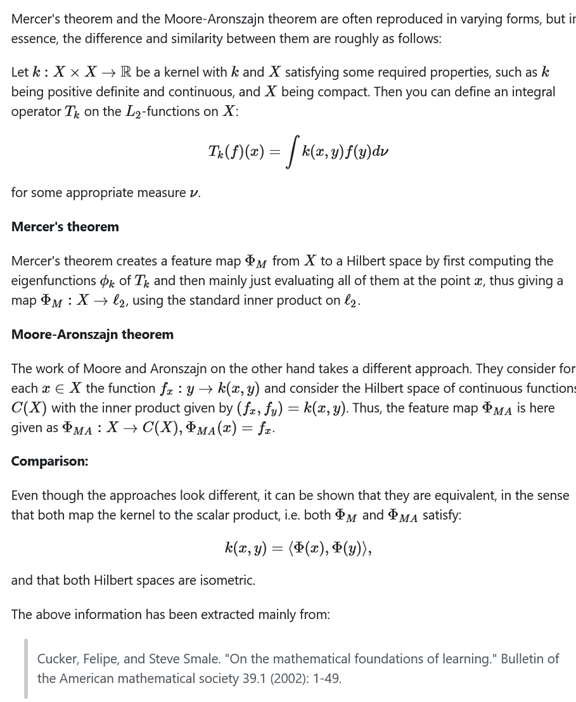

    Graph kernels

        Labeled
            Shortest paths

        Unlabeled
            Shortest paths
            3,4-Graphlets
            Random walk